In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import glob
import tensorflow as tf

In [2]:
image = glob.glob("D:/lumor_segementation/kits19-master/processed_image/*/*.png")
label = glob.glob("D:/lumor_segementation/kits19-master/processed_segmen/*/*.png")
print("num of train img: ", len(image))
print("num of label img: ", len(label))

num of train img:  45424
num of label img:  45424


In [3]:
image[-5:]

['D:/lumor_segementation/kits19-master/processed_image\\case_00209\\image00097.png',
 'D:/lumor_segementation/kits19-master/processed_image\\case_00209\\image00098.png',
 'D:/lumor_segementation/kits19-master/processed_image\\case_00209\\image00099.png',
 'D:/lumor_segementation/kits19-master/processed_image\\case_00209\\image00100.png',
 'D:/lumor_segementation/kits19-master/processed_image\\case_00209\\image00101.png']

In [4]:
label[-5:]

['D:/lumor_segementation/kits19-master/processed_segmen\\case_00209\\segmentation00097.png',
 'D:/lumor_segementation/kits19-master/processed_segmen\\case_00209\\segmentation00098.png',
 'D:/lumor_segementation/kits19-master/processed_segmen\\case_00209\\segmentation00099.png',
 'D:/lumor_segementation/kits19-master/processed_segmen\\case_00209\\segmentation00100.png',
 'D:/lumor_segementation/kits19-master/processed_segmen\\case_00209\\segmentation00101.png']

In [5]:
#对图像和标签做乱序处理（打乱）
#但注意要用同一个index对其做乱序，确保乱序后图像与标签仍一一对应
index = np.random.permutation(len(image))
image = np.array(image)[index]
label = np.array(label)[index]

In [6]:
all_ds = tf.data.Dataset.from_tensor_slices((image,label))
all_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [7]:
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 3)
    img = tf.image.resize(img,(256,256))
    return img

def read_png_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 1)
    img = tf.image.resize(img,(256,256))
    return img

#对图像和标签做标准化
def normalize(img,mask):
    img = tf.cast(img, tf.float32)
    #归一化到(0,1)之间
    img = img / 127.5 - 1
    #标注就是简单的分类，int32足够
    mask = tf.cast(mask, tf.int8)
    return img, mask

In [28]:
#测试
ex_img = read_png(image[100])
ex_label = read_png_label(label[100])
print("img shape: ", ex_img.shape)
print("label shape: ", ex_label.shape)

img shape:  (256, 256, 3)
label shape:  (256, 256, 1)


In [29]:
ex_img, ex_label = normalize(ex_img,ex_label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


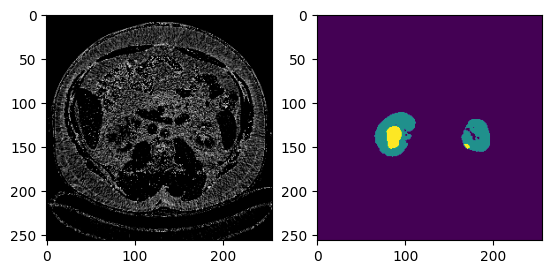

In [30]:
#用plt一行两图的格式显示图像和其对应标注
plt.subplot(1,2,1)
plt.imshow(ex_img)
plt.subplot(1,2,2)
plt.imshow(ex_label)

In [31]:
background = 0
kidney = 0
lumor = 0
for i in range(256):
    for j in range(256):
        if ex_label[i][j] == 1:
            kidney = kidney + 1
        elif (ex_label[i][j] == 2):
            lumor = lumor + 1
        else:
            background = background + 1

In [35]:
print("background: ",background)
print("kidney: ",kidney)
print("lumor: ",lumor)
if(background + kidney + lumor) != 256 * 256:
    print("error")

background:  63028
kidney:  2129
lumor:  379


In [36]:
#批处理训练图+标注的函数
def load_image(img_path,mask_path):
    img = read_png(img_path)
    mask = read_png_label(mask_path)
    
    #共同左右翻转
    #这也是图像增强的方法之一
    #这里确保要翻转都翻转就行了
    #if tf.random.uniform(())>0.5:
        #img = tf.image.flip_left_right(img)
        #mask = tf.image.flip_left_right(mask)
    
    #标准化
    img,mask=normalize(img,mask)
    
    return img,mask

In [37]:
all_ds = all_ds.map(load_image)

In [38]:
all_ds

<MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.int8, name=None))>

In [39]:
test_count = int(len(image)*0.2)
train_count = len(image) - test_count
print("train count: ", train_count)
print("test count: ", test_count)

train count:  36340
test count:  9084


In [40]:
#定义一些训练的参数
BATCH_SIZE = 8    
BUFFER_SIZE = 200
step_per_epoch = train_count // BATCH_SIZE       #训练步长
val_step = test_count // BATCH_SIZE              #测试步长

In [41]:
train_ds = all_ds.skip(test_count)
test_ds = all_ds.take(test_count)

In [42]:
#对训练集 shuffle + batch
#对测试机 batch
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [43]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.int8, name=None))>

In [44]:
#构建U-NET模型

In [45]:
#封装下采样
class DownSample(tf.keras.layers.Layer):
    def __init__(self, units):
        super(DownSample, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(units,kernel_size=3,
                                           padding='same')
        self.conv2 = tf.keras.layers.Conv2D(units,kernel_size=3,
                                           padding='same')
        self.pool = tf.keras.layers.MaxPooling2D()
        
    def call(self, x, Is_Pool=True):
        if(Is_Pool):
            x = self.pool(x)   #下采样
        x = self.conv1(x)
        x = tf.nn.relu(x)  #采样后需要激活
        x = self.conv2(x)
        x = tf.nn.relu(x)
        return x

In [46]:
#封装上采样
class UpSample(tf.keras.layers.Layer):
    def __init__(self, units):
        super(UpSample, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(units,kernel_size=3,
                                           padding='same')
        self.conv2 = tf.keras.layers.Conv2D(units,kernel_size=3,
                                           padding='same')
        self.deconv = tf.keras.layers.Conv2DTranspose(units//2,kernel_size=2,
                                                     strides=2,padding='same')
        #反卷积上采样时单元数减半(units//2),图像大小加倍(strides=2)
        
    def call(self, x):
        x = self.conv1(x)
        x = tf.nn.relu(x)  #采样后需要激活
        x = self.conv2(x)
        x = tf.nn.relu(x)
        x = self.deconv(x)
        x = tf.nn.relu(x)
        return x

In [47]:
class Unet_model(tf.keras.Model):
    def __init__(self):
        super(Unet_model, self).__init__()
        self.down1 = DownSample(64)
        self.down2 = DownSample(128)
        self.down3 = DownSample(256)
        self.down4 = DownSample(512)
        self.down5 = DownSample(1024)
        
        self.middle_up = tf.keras.layers.Conv2DTranspose(512,kernel_size=2,
                                                 strides=2,padding='same')
        
        self.up1 = UpSample(512)
        self.up2 = UpSample(256)
        self.up3 = UpSample(128)
        
        self.conv_last = DownSample(64)  #Is_pool=False
        
        self.last = tf.keras.layers.Conv2D(3,
                                          kernel_size=1,
                                          padding='same')
        #语义分割本质上是分类问题，分3类则最终输出3个通道
        
    #前向传播
    def call(self,x):
        x1 = self.down1(x,Is_Pool=False)   #初始第一个是没有下采样的
        x2 = self.down2(x1)                #这里调用的是其call方法
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        
        x5 = self.middle_up(x5)
        
        x5 = tf.concat([x4,x5],axis=-1)   #在通道维度上合并，同尺寸，512+512得到共1024通道
        x5 = self.up1(x5)
        
        x5 = tf.concat([x3,x5],axis=-1)  
        x5 = self.up2(x5)
        
        x5 = tf.concat([x2,x5],axis=-1)  
        x5 = self.up3(x5)
        
        x5 = tf.concat([x1,x5],axis=-1)
        x5 = self.conv_last(x5,Is_Pool=False)  #最后不下采样
        
        x5 = self.last(x5)
        
        return x5

In [48]:
model = Unet_model()  #实例化定义好的U-NET模型

In [49]:
#每50个batch 约 18s
#每个train_epoch 大约 18s x (4500 / 50) = 18s x 90 = 18min x 1.5 = 27min 

In [50]:
#自定义训练
#实例化优化器opt
opt = tf.keras.optimizers.Adam(0.0001)
#实例化损失函数（评估）
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

class MeanIOU(tf.keras.metrics.MeanIoU):   #父类的方法需要y_true 和 y_pred有相同形状
    def __call__(self, y_true, y_pred, sample_weight=None):    #调用时默认会寻找call方法
        #y_pred原本是长度为3张量
        y_pred = tf.argmax(y_pred,axis=-1)
        return super().__call__(y_true, y_pred,sample_weight=sample_weight)
    
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_acc')
train_iou = MeanIOU(3, name='train_iou')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acc')
test_iou = MeanIOU(3, name='test_iou')

def train_step(images, labels):
    with tf.GradientTape() as tape:
        #调用模型得到预测结果
        predictions = model(images)   
        #对比预测结果与标注得到损失
        loss = loss_fn(labels,predictions) 
    #用经典反向传播得到梯度
    gradients = tape.gradient(loss, model.trainable_variables)  
    #应用梯度对参数做优化
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    #得到我们能看懂的损失值
    train_loss(loss)
    #得到我们能看懂的准确率
    train_acc(labels,predictions)
    #IOU值
    train_iou(labels,predictions)
    
def test_step(images, labels):
    predictions = model(images)
    loss = loss_fn(labels,predictions)
    
    test_loss(loss)
    test_acc(labels,predictions)
    #IOU值
    test_iou(labels,predictions)

EPOCHS = 1
    
for epoch in range(EPOCHS):
    train_index = 1
    test_index = 1
    #在下一个epoch开始时，重置评估指标
    train_loss.reset_states()
    train_acc.reset_states()
    train_iou.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()
    test_iou.reset_states()
    
    print("training ", epoch+1, " epoch: waiting......")
    for images,labels in train_ds:
        if(train_index % 50 == 0):
            print("batch ", train_index, "/", step_per_epoch)
        train_index = train_index + 1
        train_step(images,labels)
        
    print("testing......")
    for images,labels in test_ds:
        if(test_index % 50 == 0):
            print("batch ", test_index, "/", val_step)
        test_index = test_index + 1
        test_step(images,labels)
    
    print("the epoch", epoch+1, " result: ")
    template1 = "train --> Loss: {:.2f}, Accuracy: {:.2f}, IOU: {:.2f}"
    print(template1.format(train_loss.result(), train_acc.result()*100, train_iou.result()))
    template2 = "test  --> Loss: {:.2f}, Accuracy: {:.2f}, IOU: {:.2f}"
    print(template2.format(test_loss.result(), test_acc.result()*100, test_iou.result()))

training  1  epoch: waiting......
batch  50 / 4542
batch  100 / 4542
batch  150 / 4542
batch  200 / 4542
batch  250 / 4542
batch  300 / 4542
batch  350 / 4542
batch  400 / 4542
batch  450 / 4542
batch  500 / 4542
batch  550 / 4542
batch  600 / 4542
batch  650 / 4542
batch  700 / 4542
batch  750 / 4542
batch  800 / 4542
batch  850 / 4542
batch  900 / 4542
batch  950 / 4542
batch  1000 / 4542
batch  1050 / 4542
batch  1100 / 4542
batch  1150 / 4542
batch  1200 / 4542
batch  1250 / 4542
batch  1300 / 4542
batch  1350 / 4542
batch  1400 / 4542
batch  1450 / 4542
batch  1500 / 4542
batch  1550 / 4542
batch  1600 / 4542
batch  1650 / 4542
batch  1700 / 4542
batch  1750 / 4542
batch  1800 / 4542
batch  1850 / 4542
batch  1900 / 4542
batch  1950 / 4542
batch  2000 / 4542
batch  2050 / 4542
batch  2100 / 4542
batch  2150 / 4542
batch  2200 / 4542
batch  2250 / 4542
batch  2300 / 4542
batch  2350 / 4542
batch  2400 / 4542
batch  2450 / 4542
batch  2500 / 4542
batch  2550 / 4542
batch  2600 / 454

In [51]:
EPOCHS = 15
epoch = 1
    
while epoch < EPOCHS:
    train_index = 1
    test_index = 1
    #在下一个epoch开始时，重置评估指标
    train_loss.reset_states()
    train_acc.reset_states()
    train_iou.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()
    test_iou.reset_states()
    
    print("training ", epoch+1, " epoch: waiting......")
    for images,labels in train_ds:
        if(train_index % 50 == 0):
            print("batch ", train_index, "/", step_per_epoch)
        train_index = train_index + 1
        train_step(images,labels)
        
    print("testing......")
    for images,labels in test_ds:
        if(test_index % 50 == 0):
            print("batch ", test_index, "/", val_step)
        test_index = test_index + 1
        test_step(images,labels)
    
    print("the epoch", epoch+1, " result: ")
    template1 = "train --> Loss: {:.2f}, Accuracy: {:.2f}, IOU: {:.2f}"
    print(template1.format(train_loss.result(), train_acc.result()*100, train_iou.result()))
    template2 = "test  --> Loss: {:.2f}, Accuracy: {:.2f}, IOU: {:.2f}"
    print(template2.format(test_loss.result(), test_acc.result()*100, test_iou.result()))
    
    epoch = epoch + 1

training  2  epoch: waiting......
batch  50 / 4542
batch  100 / 4542
batch  150 / 4542
batch  200 / 4542
batch  250 / 4542
batch  300 / 4542
batch  350 / 4542
batch  400 / 4542
batch  450 / 4542
batch  500 / 4542
batch  550 / 4542
batch  600 / 4542
batch  650 / 4542
batch  700 / 4542
batch  750 / 4542
batch  800 / 4542
batch  850 / 4542
batch  900 / 4542
batch  950 / 4542
batch  1000 / 4542
batch  1050 / 4542
batch  1100 / 4542
batch  1150 / 4542
batch  1200 / 4542
batch  1250 / 4542
batch  1300 / 4542
batch  1350 / 4542
batch  1400 / 4542
batch  1450 / 4542
batch  1500 / 4542
batch  1550 / 4542
batch  1600 / 4542
batch  1650 / 4542
batch  1700 / 4542
batch  1750 / 4542
batch  1800 / 4542
batch  1850 / 4542
batch  1900 / 4542
batch  1950 / 4542
batch  2000 / 4542
batch  2050 / 4542
batch  2100 / 4542
batch  2150 / 4542
batch  2200 / 4542
batch  2250 / 4542
batch  2300 / 4542
batch  2350 / 4542
batch  2400 / 4542
batch  2450 / 4542
batch  2500 / 4542
batch  2550 / 4542
batch  2600 / 454

batch  3800 / 4542
batch  3850 / 4542
batch  3900 / 4542
batch  3950 / 4542
batch  4000 / 4542
batch  4050 / 4542
batch  4100 / 4542
batch  4150 / 4542
batch  4200 / 4542
batch  4250 / 4542
batch  4300 / 4542
batch  4350 / 4542
batch  4400 / 4542
batch  4450 / 4542
batch  4500 / 4542
testing......
batch  50 / 1135
batch  100 / 1135
batch  150 / 1135
batch  200 / 1135
batch  250 / 1135
batch  300 / 1135
batch  350 / 1135
batch  400 / 1135
batch  450 / 1135
batch  500 / 1135
batch  550 / 1135
batch  600 / 1135
batch  650 / 1135
batch  700 / 1135
batch  750 / 1135
batch  800 / 1135
batch  850 / 1135
batch  900 / 1135
batch  950 / 1135
batch  1000 / 1135
batch  1050 / 1135
batch  1100 / 1135
the epoch 5  result: 
train --> Loss: 0.00, Accuracy: 99.93, IOU: 0.92
test  --> Loss: 0.00, Accuracy: 99.91, IOU: 0.90
training  6  epoch: waiting......
batch  50 / 4542
batch  100 / 4542
batch  150 / 4542
batch  200 / 4542
batch  250 / 4542
batch  300 / 4542
batch  350 / 4542
batch  400 / 4542
batch 

batch  1650 / 4542
batch  1700 / 4542
batch  1750 / 4542
batch  1800 / 4542
batch  1850 / 4542
batch  1900 / 4542
batch  1950 / 4542
batch  2000 / 4542
batch  2050 / 4542
batch  2100 / 4542
batch  2150 / 4542
batch  2200 / 4542
batch  2250 / 4542
batch  2300 / 4542
batch  2350 / 4542
batch  2400 / 4542
batch  2450 / 4542
batch  2500 / 4542
batch  2550 / 4542
batch  2600 / 4542
batch  2650 / 4542
batch  2700 / 4542
batch  2750 / 4542
batch  2800 / 4542
batch  2850 / 4542
batch  2900 / 4542
batch  2950 / 4542
batch  3000 / 4542
batch  3050 / 4542
batch  3100 / 4542
batch  3150 / 4542
batch  3200 / 4542
batch  3250 / 4542
batch  3300 / 4542
batch  3350 / 4542
batch  3400 / 4542
batch  3450 / 4542
batch  3500 / 4542
batch  3550 / 4542
batch  3600 / 4542
batch  3650 / 4542
batch  3700 / 4542
batch  3750 / 4542
batch  3800 / 4542
batch  3850 / 4542
batch  3900 / 4542
batch  3950 / 4542
batch  4000 / 4542
batch  4050 / 4542
batch  4100 / 4542
batch  4150 / 4542
batch  4200 / 4542
batch  4250 

batch  900 / 1135
batch  950 / 1135
batch  1000 / 1135
batch  1050 / 1135
batch  1100 / 1135
the epoch 12  result: 
train --> Loss: 0.00, Accuracy: 99.95, IOU: 0.95
test  --> Loss: 0.00, Accuracy: 99.94, IOU: 0.94
training  13  epoch: waiting......
batch  50 / 4542
batch  100 / 4542
batch  150 / 4542
batch  200 / 4542
batch  250 / 4542
batch  300 / 4542
batch  350 / 4542
batch  400 / 4542
batch  450 / 4542
batch  500 / 4542
batch  550 / 4542
batch  600 / 4542
batch  650 / 4542
batch  700 / 4542
batch  750 / 4542
batch  800 / 4542
batch  850 / 4542
batch  900 / 4542
batch  950 / 4542
batch  1000 / 4542
batch  1050 / 4542
batch  1100 / 4542
batch  1150 / 4542
batch  1200 / 4542
batch  1250 / 4542
batch  1300 / 4542
batch  1350 / 4542
batch  1400 / 4542
batch  1450 / 4542
batch  1500 / 4542
batch  1550 / 4542
batch  1600 / 4542
batch  1650 / 4542
batch  1700 / 4542
batch  1750 / 4542
batch  1800 / 4542
batch  1850 / 4542
batch  1900 / 4542
batch  1950 / 4542
batch  2000 / 4542
batch  2050

In [53]:
model.save_weights("D:/lumor_segementation/kits19-master/model/U-Net_for_15_epoches.h5")

1/1 [==============================] - 4s 4s/step


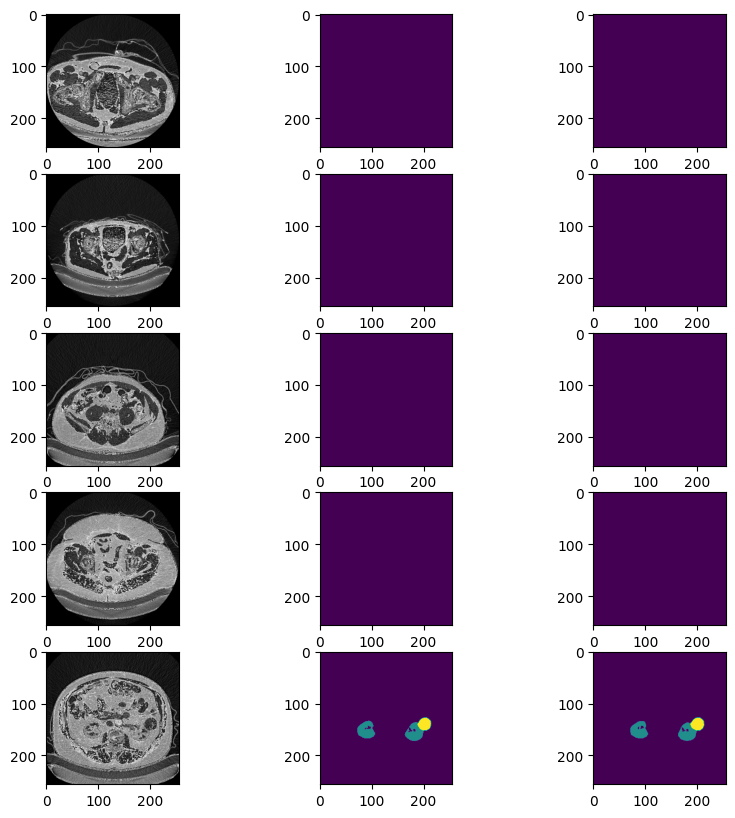

In [54]:
#从loss和acc来看，训练3个epoch后性能已经非常优秀，现在我们可视化查看一下效果
for image, mask in test_ds.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[...,tf.newaxis]
    
    plt.figure(figsize=(10,10))
    for i in range(5):
        plt.subplot(5,3,i*3+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(5,3,i*3+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(5,3,i*3+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))

In [31]:
#可以看到预测效果还是不错的
#下面我们用IOU指标评估一下结果
class MeanIOU(tf.keras.metrics.MeanIoU):   #父类的方法需要y_true 和 y_pred有相同形状
    def __call__(self, y_true, y_pred, sample_weight=None):    #调用时默认会寻找call方法
        #y_pred原本是长度为3张量
        y_pred = tf.argmax(y_pred,axis=-1)
        return super().__call__(y_true, y_pred,sample_weight=sample_weight)
    
test_iou = MeanIOU(3, name='test_iou')
    
def test_step(images, labels):
    predictions = model(images)
    test_iou(labels,predictions)
    
test_iou.reset_states()
for images,labels in test_ds:
    test_step(images,labels)
    
print("Test IOU: {:.3f}",test_iou.result())

Test IOU: {:.3f} tf.Tensor(0.8916585, shape=(), dtype=float32)


In [32]:
print("Test IOU: {:.3f}".format(test_iou.result()))

Test IOU: 0.892


In [49]:
#下面我们在官方没给标签的部分做测试
final_test = glob.glob("D:/lumor_segementation/kits19-master/final_test/*/*.png")
print("num of final_test: ", len(final_test))

num of final_test:  4050


In [50]:
def load_test(img_path):
    img = read_png(img_path)
    
    img = tf.cast(img, tf.float32)
    #归一化到(0,1)之间
    img = img / 127.5 - 1
    
    return img

1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


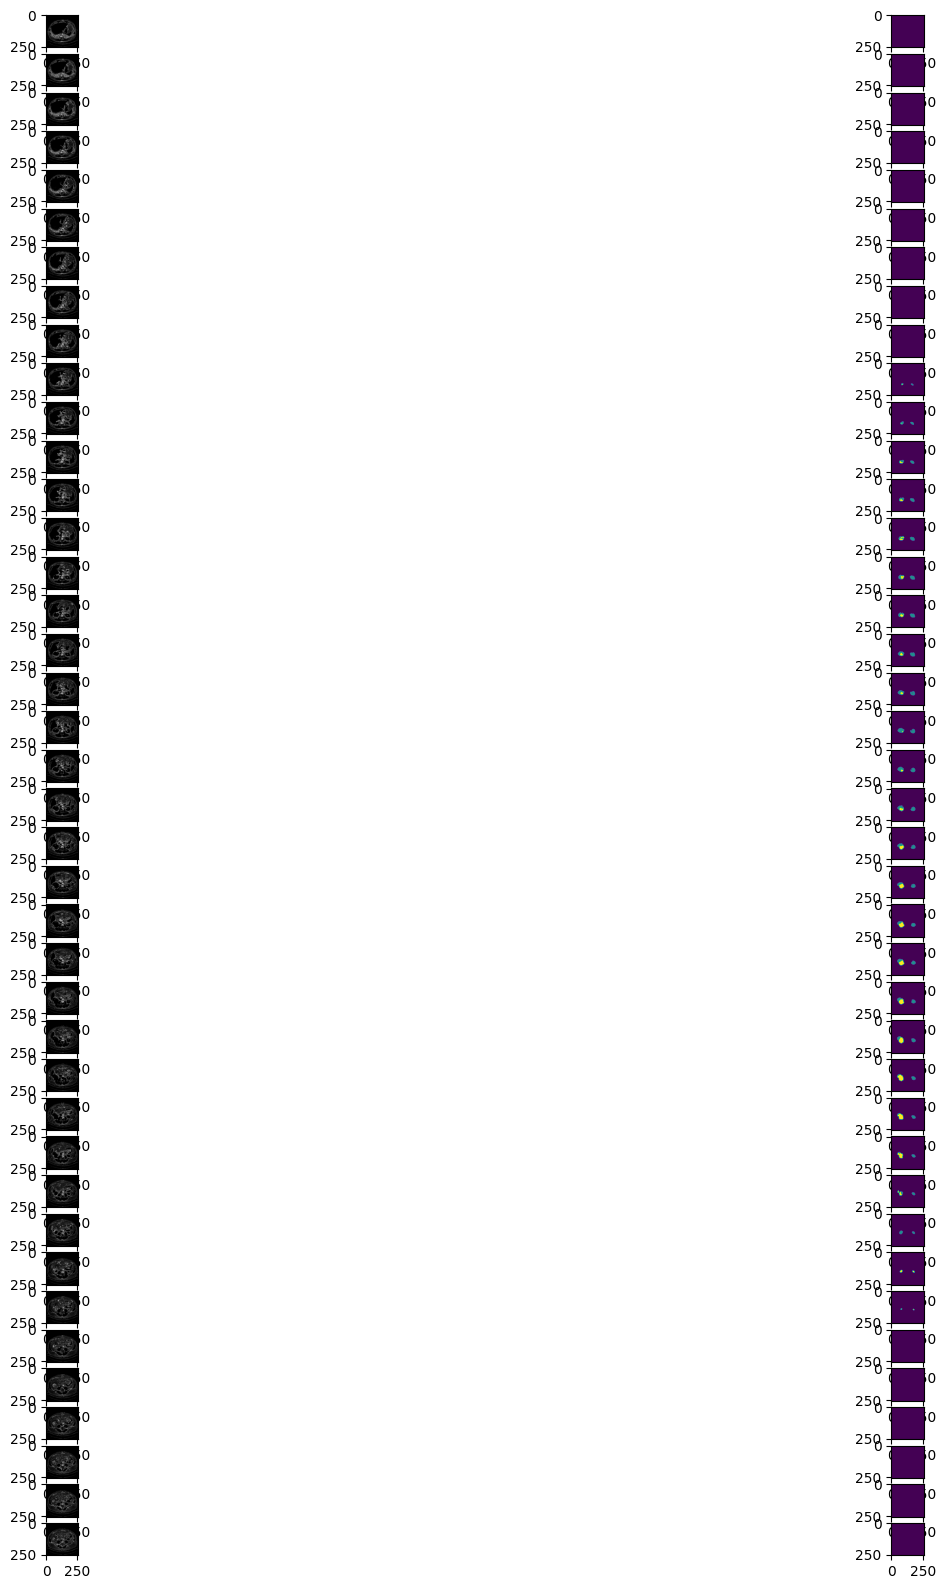

In [65]:
final_test_num = 40
plt.figure(figsize=(20,20))
for index in range(final_test_num):
    img_decode = load_test(final_test[index])
    img_decode_ex = tf.expand_dims(img_decode,0)
    pred_mask = model.predict(img_decode_ex)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[...,tf.newaxis]

    plt.subplot(final_test_num,2,index*2+1)
    plt.imshow(img_decode)
    plt.subplot(final_test_num,2,index*2+2)
    plt.imshow(pred_mask[0])

In [ ]:
#再训练两个epoch
EPOCHS = 5
epoch = 3

train_iou = MeanIOU(3, name='train_iou')
test_iou = MeanIOU(3, name='test_iou')
    
def train_step(images, labels):
    with tf.GradientTape() as tape:
        #调用模型得到预测结果
        predictions = model(images)   
        #对比预测结果与标注得到损失
        loss = loss_fn(labels,predictions) 
    #用经典反向传播得到梯度
    gradients = tape.gradient(loss, model.trainable_variables)  
    #应用梯度对参数做优化
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    #得到我们能看懂的损失值
    train_loss(loss)
    #得到我们能看懂的准确率
    train_acc(labels,predictions)
    #IOU值
    train_iou(labels,predictions)
    
def test_step(images, labels):
    predictions = model(images)
    loss = loss_fn(labels,predictions)
    
    test_loss(loss)
    test_acc(labels,predictions)
    #IOU值
    test_iou(labels,predictions)
    
while epoch < EPOCHS:
    train_index = 1
    test_index = 1
    #在下一个epoch开始时，重置评估指标
    train_loss.reset_states()
    train_acc.reset_states()
    train_iou.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()
    test_iou.reset_states()
    
    print("training ", epoch+1, " epoch: waiting......")
    for images,labels in train_ds:
        if(train_index % 50 == 0):
            print("batch ", train_index, "/", step_per_epoch)
        train_index = train_index + 1
        train_step(images,labels)
        
    print("testing......")
    for images,labels in test_ds:
        if(test_index % 50 == 0):
            print("batch ", test_index, "/", val_step)
        test_index = test_index + 1
        test_step(images,labels)
    
    print("the ", epoch+1, " result: ")
    template = 'Epoch {:.0f}, Loss: {:.2f}, Accuracy: {:.2f}, \
                IOU: {:.3f}, Test Loss: {:.2f}, \
                Test Accuracy: {:.2f}, Test IOU: {:.3f}'
    print(template.format(epoch+1,
                         train_loss.result(),
                         train_acc.result()*100,
                         train_iou.result(),
                         test_loss.result(),
                         test_acc.result()*100,
                         test_iou.result()
                         ))

training  4  epoch: waiting......
batch  50 / 4542
batch  100 / 4542
batch  150 / 4542
batch  200 / 4542
batch  250 / 4542
batch  300 / 4542
batch  350 / 4542
batch  400 / 4542
batch  450 / 4542
batch  500 / 4542
batch  550 / 4542
batch  600 / 4542
batch  650 / 4542
batch  700 / 4542
batch  750 / 4542
batch  800 / 4542
batch  850 / 4542
batch  900 / 4542
batch  950 / 4542
batch  1000 / 4542
batch  1050 / 4542
batch  1100 / 4542
batch  1150 / 4542
batch  1200 / 4542
batch  1250 / 4542
batch  1300 / 4542
batch  1350 / 4542
batch  1400 / 4542
batch  1450 / 4542
batch  1500 / 4542
batch  1550 / 4542
batch  1600 / 4542
batch  1650 / 4542
batch  1700 / 4542
batch  1750 / 4542
batch  1800 / 4542
batch  1850 / 4542
batch  1900 / 4542
batch  1950 / 4542
batch  2000 / 4542
batch  2050 / 4542
batch  2100 / 4542
batch  2150 / 4542
batch  2200 / 4542
batch  2250 / 4542
batch  2300 / 4542
batch  2350 / 4542
batch  2400 / 4542
batch  2450 / 4542
batch  2500 / 4542
batch  2550 / 4542
batch  2600 / 454